In [91]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.raw_engine

In [166]:
df = pd.read_sql("SELECT * FROM BTCUSD_1h",engine)
df.set_index('Date',inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-05 15:00:00,9075.643555,9096.036133,9060.328125,9096.036133,9096.036133,0.000000e+00
2020-03-05 16:00:00,9094.782227,9124.201172,9091.835938,9105.301758,9105.301758,0.000000e+00
2020-03-05 17:00:00,9106.311523,9119.547852,9098.045898,9110.729492,9110.729492,2.937201e+08
2020-03-05 18:00:00,9111.915039,9123.532227,9101.458008,9120.463867,9120.463867,4.824269e+07
2020-03-05 19:00:00,9118.181641,9137.944336,9109.423828,9137.944336,9137.944336,3.094938e+07
...,...,...,...,...,...,...
2022-03-01 10:00:00,43227.777344,43473.699219,42983.214844,43473.699219,43473.699219,7.879721e+08
2022-03-01 11:00:00,43484.906250,43661.972656,43443.812500,43537.582031,43537.582031,8.142111e+08
2022-03-01 12:00:00,43542.511719,44543.996094,43542.511719,44543.996094,44543.996094,2.484015e+09


o,h,l,c는 실상 동일하므로 피쳐를 조합해 새로운 피쳐를 만들어준다.

In [175]:
class FeatureTransformer():
    def __init__(self, df):
        self.price = df['Adj Close']
        self.high = df['High']
        self.low = df['Low']
        self.volume = df['Volume']
        return

    def get_macd(self):
        price = self.price
        exp12 = price.ewm(span = 12, adjust=False).mean()
        exp26 = price.ewm(span = 26, adjust=False).mean()
        macd = exp12 - exp26
        exp = macd.ewm(span=9, adjust=False).mean()
        return exp

    def get_rsi(self, period=14):
        close_price = self.price
        delta = close_price.diff()
        gains,drops = delta.copy(), delta.copy()
        gains[gains < 0] = 0
        drops[drops > 0] = 0
        au = gains.ewm(com=period-1, min_periods=period).mean()
        ad = drops.abs().ewm(com=period-1, min_periods=period).mean()
        rs = au / ad
        rsi = pd.Series(100 - (100 / (1 + rs)))
        return rsi

    def get_vwap(self):
        volumes = self.volume
        price = self.price
        vwap = ((volumes * price).cumsum()) / volumes.cumsum()
        return vwap
    
    def get_stochastic(self, n=14, m=5):
        n_high = self.high.rolling(window=n, min_periods=1).max()
        n_low = self.low.rolling(window=n, min_periods=1).min()
        fast_k = (self.price - self.low) / (n_high - n_low) * 100
        fast_d = fast_k.ewm(span=m).mean()
        return (fast_k, fast_d)

    def transform(self):
        fast_k, fast_d = self.get_stochastic()
        df = pd.DataFrame({'Price': self.price, 'Gap': (self.high - self.low) / self.low,
                    'Rsi': self.get_rsi(14), 'Macd': self.get_macd(),
                    'Vwap':self.get_vwap(), 'Fast_k': fast_k,
                    'Fast_d': fast_d})
        df.dropna(inplace=True)
        print("Create new feature complete")
        return df
feature_tf = FeatureTransformer(df)
X = feature_tf.transform()
X


Create new feature complete


,Price,Gap,Rsi,Macd,Vwap,Fast_k,Fast_d
Date,,,,,,,
2020-03-06 05:00:00,9100.071289,0.004717,53.776258,-4.959533,9084.801055,36.957776,19.806621
2020-03-06 06:00:00,9109.397461,0.003299,56.473186,-4.924357,9085.905747,14.627714,18.077686
2020-03-06 07:00:00,9108.590820,0.003117,56.167937,-4.451860,9086.872084,2.945434,13.028477
2020-03-06 08:00:00,9121.207031,0.003344,59.825530,-3.518598,9091.496519,16.786396,14.281965
2020-03-06 09:00:00,9134.069336,0.001660,63.197299,-2.132229,9091.496519,9.534254,12.698680
...,...,...,...,...,...,...,...
2022-03-01 10:00:00,43473.699219,0.011411,74.142861,1112.398909,19785.683460,22.256333,9.665900
2022-03-01 11:00:00,43537.582031,0.005022,74.637522,1093.406138,19785.694793,4.368048,7.899949
2022-03-01 12:00:00,44543.996094,0.023000,80.852259,1086.323296,19785.730832,62.930626,26.243508


모델을 생성하고 비교해보자.

mse: 60870026.82662437, alpha: 1000
mse: 50031478.0612212, alpha: 300
mse: 46897773.98962693, alpha: 100
mse: 46290386.47718901, alpha: 30
mse: 46228522.54356434, alpha: 10
mse: 46237544.84508101, alpha: 1


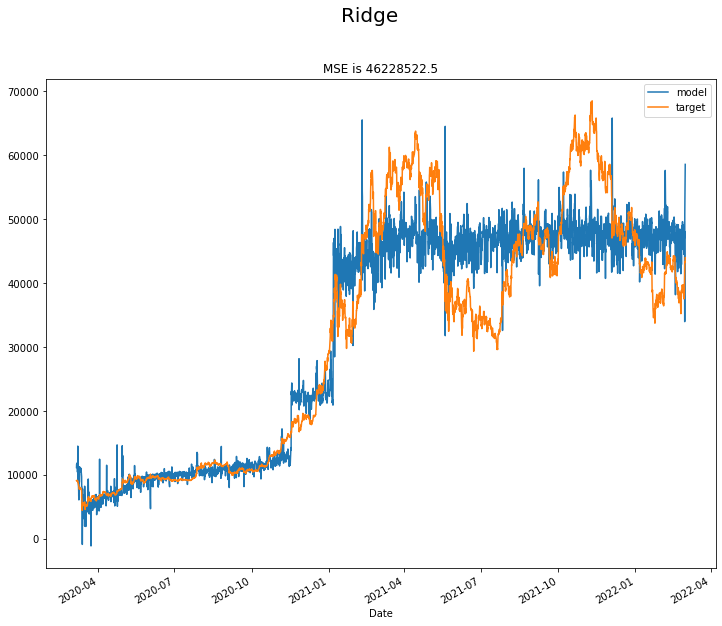

In [214]:
from sklearn.compose import TransformedTargetRegressor
class MyModel():
    def __init__(self):
        self.X = None
        self.y = None
        self.model = None

    def create_train_data(self, df):
        X = df.drop(['Price'],axis=1).iloc[:-1, ::]
        y = df['Price'].iloc[1:] #비트코인의 봉 평균가.
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=24)
        self.X = test_X
        self.y = test_y
        return train_X, test_X, train_y, test_y

    def get_best_alpha(self, train_X, test_X, train_y, test_y):
        best_alpha = 1
        best_mse = float('inf')
        for i in [1000,300,100,30,10,1]:
            self.model.set_params(regressor__regulator__alpha=i)
            self.model.fit(train_X, train_y) #바꾼 알파로 다시 피팅해본다.
            pred = self.model.predict(test_X)
            mse = ((test_y - pred) ** 2).mean()
            if best_mse > mse:
                best_mse = mse
                best_alpha = i
            print(f'mse: {mse}, alpha: {i}')
        return best_alpha

    def create_model(self, model_class):
        pipeline = Pipeline([
            ("std_scaler", StandardScaler()),
            ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
            ('regulator', model_class)
        ])
        self.model = TransformedTargetRegressor(regressor=pipeline,transformer=StandardScaler())
        train_X, test_X, train_y, test_y = self.create_train_data(X)
        alpha = self.get_best_alpha(train_X, test_X, train_y, test_y)
        self.model.set_params(regressor__regulator__alpha=alpha)
        self.model.fit(train_X, train_y)
        return 
    
    def visualize_plot(self, name):
        target = self.y
        pred = pd.Series(self.model.predict(self.X), index=target.index)
        plt.figure(figsize=(12,10))
        pred.sort_index().plot(label='model')
        target.sort_index().plot(label='target')
        plt.suptitle(f'{name}',fontsize=20)
        mse = ((target - pred) ** 2).mean()
        plt.title(f'MSE is {mse:.1f}')
        plt.legend()

model = MyModel()
model.create_model(Ridge(alpha=10,solver="sparse_cg",random_state=42,fit_intercept=True))
model.visualize_plot("Ridge")


mse: 353268271.7626627, alpha: 1000
mse: 353268271.7626627, alpha: 300
mse: 353268271.7626627, alpha: 100
mse: 353268271.7626627, alpha: 30
mse: 353268271.7626627, alpha: 10
mse: 244041910.05447152, alpha: 1


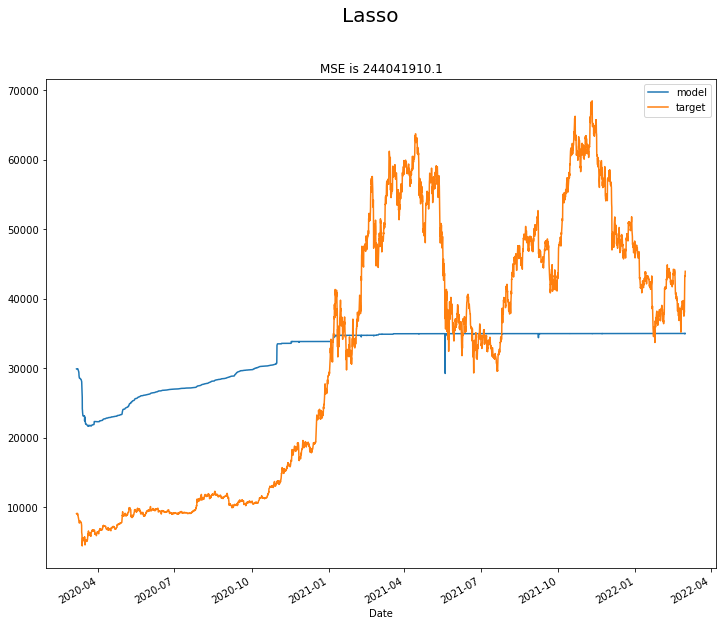

In [213]:
model = MyModel()
model.create_model(Lasso(alpha=10,fit_intercept=True,random_state=42))
model.visualize_plot("Lasso")